# Network of painters based on their locations throughout time - Graph construction and analysis

<u> **Description:**</u> The work contained in this notebook is part of a bigger project, only containing the construction of a painter network based on locations of painters throughout years, and analyzing, visualizing this network. 

To my understanding, I created the most extensive public dataset of painters. I took data from a painting dataset of WikiArt (very clean) with roughly 3000 painters, combined it with the Art500k dataset (messy, but with more data) with roughly 20000 instances (many of which are duplicate instances with some differences in name, or not human beings, e.g. painting workshops), joined them, and selected only those instances that appear in Wikidata. For these instances, I queried properties such as citizenship and work locations from Wikidata.<br>
This resulted in a dataset of roughly 10000 painters, with 25-30 attributes:

- Biography data: Nationality/citizenship, name, birth and death years and places, gender
- Artistic style data
- Locations of activity (sometimes with years)
- Occupations list (e.g. "painter, sculptor, litographer")
- Influences: on painters, and from painters, pupils, teachers
- Friends, coworkers (limited data)
- Quantities of paintings, in styles, etc.

There is information on ~10000 painters from the 11th century (even before, but with low information) to the 21st, their locations, time data, bio data, how many artworks they painted per style, what movement they belonged to, a list of some of the painters who influenced them and who they influenced, the school they studied at and friends and coworkers. 

I already ran some analysis of styles and movements of the network in the past for different projects. In this particular work, I wanted to gain insights about what common properties do painters have, that were connected by living at the same places at the same time (approximately, because temporal data is sparse and I had to make compromises).<br>

The main research questions are:

- **What properties does such a painter network have?**
- **What communities can be found in this network, and properties do the separate communities have?**

Are these communities fairly evenly distributed in percentage of females, or vary a lot? From simple prior analysis, I found that centuries ago the surroundings of a painter pretty much determined his/her artistic style too (this must have been an effect of social contagion more than homophily, as many painters e.g. Rembrandt never left their country to work somewhere else with different artistic style, most painters just adjusted to their place). Assumably, as transportation infrastructure developed, the various styles started spreading more, and while location (in time) used to be a good indicator of an artistic style, it does not have as much of an impact anymore. It would be interesting to find such insights aside stylistic attributes.

I aim to find similar findings, by first analyzing the (processed) network, and then analyzing the communities directly in such a network.


The final community structure, with some explanation will be a visualized nested blockmodel, from which one can also gain further insights, such as whether intra-community connections are stronger than inter-community ones (hinting at assortivity).

Original data: https://raw.githubusercontent.com/me9hanics/PainterPalette/main/datasets/artists.csv

## Imports, initial procedures

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw as pwl
import ast #simple string to list/dict methods

from data_processing import process
from data_processing import plot
from data_processing import measures

#Dataset of painters/artists:
artists = pd.read_csv("data/artists.csv").drop(columns=["Type", "Contemporary"])#Type and contemporary are artificial columns

Let's see some of the data we have:

In [2]:
artists[10:15]

,artist,Nationality,citizenship,gender,styles,movement,Art500k_Movements,birth_place,death_place,birth_year,...,StylesYears,occupations,PaintingsExhibitedAt,PaintingsExhibitedAtCount,PaintingSchool,Influencedby,Influencedon,Pupils,Teachers,FriendsandCoworkers
10,Friedrich Schroder-Sonnenstern,German,Germany,male,Art Brut,Outsider art (Art brut),{Outsider art (Art brut):10},Sovetsk,Berlin,1892.0,...,Art Brut:1948-1965,"painter, drawer",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,D. Jeffrey Mims,American,United States of America,male,Contemporary Realism,Classical Realism,{Classical Realism:10},North Carolina,NaN,1954.0,...,Contemporary Realism:1954-1997,"painter, politician",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Nuno Gonçalves,Portuguese,Kingdom of Portugal,male,Early Renaissance,Early Renaissance,{Early Renaissance:10},NaN,NaN,1425.0,...,Early Renaissance:1450-1490,"portraitist, painter, musician, researcher","Lisbon, Portugal","{Lisbon:1},{Portugal:1}",NaN,"National Museum of Ancient Art (MNAA), Lisbon,...",NaN,NaN,NaN,NaN
13,Alexander Khvostenko-Khvostov,"Russian,Ukrainian",Russian Empire,male,"Art Nouveau (Modern), Constructivism, Expressi...",Avant-garde,"{Avant-garde,Constructivism:21}","Borisovka, Borisovsky District, Belgorod Oblast",Kyiv,1885.0,...,"Art Nouveau (Modern):1917-1948,Socialist Reali...","visual artist, scenographer, graphic artist, p...",NaN,NaN,ARMU (Association of Revolutionary Masters of ...,NaN,NaN,NaN,"Aleksandra Ekster,","Victor Palmov,David Burliuk,Oleksandr Bogomazo..."
14,Jose Ferraz de Almeida Junior,Brazilian,Brazil,male,"Academicism, Realism",Realism,{Realism:64},Itu,Piracicaba,1850.0,...,"Realism:1850-1899,Academicism:1850-1895",painter,"Brazil, Rio de Janeiro, Sao Paulo","{Sao Paulo:30},{Brazil:36},{Rio de Janeiro:4}",NaN,NaN,NaN,NaN,NaN,NaN


We see that years in birth/first/last year are floats instead of ints, this is because of `NaN` values being floats and there is no integer NaN. The various attributes can be confusing, but we need only the locations of painters, and basic attributes such as gender, birth year, death year, nationality, and their artistic movement.

## Creating the network:

- Use painters as nodes (with metadata)
- Calculate a "time-location-similarity" measure of pairs of painters based on temporal and location data
- Add edges between painters with a similarity above 0
- Threshold the network to arrive at a reasonable network.


### Preprocessing:

The data is imperfect in some instances. For example, due to mismatches of the original datasets from which this dataset was created from it can happen that an instance has different "last year" (last year of a painting in the Art500k database) and "death year" (from Wikidata). Let's see an example of this:

In [3]:
artists[['artist', 'Nationality', 'citizenship',
         'birth_year','death_year' , 'FirstYear','LastYear',
         'styles_extended', 'StylesYears', 'locations']][artists['artist']=='Rupert Bunny']

,artist,Nationality,citizenship,birth_year,death_year,FirstYear,LastYear,styles_extended,StylesYears,locations
831,Rupert Bunny,Australian,Australia,1864.0,1947.0,1890.0,1989.0,"{Art Nouveau (Modern):2},{Impressionism:52},{S...","Impressionism:1891-1989,Art Nouveau (Modern):1...",['Paris']


The last year of activity (LastYear) is bigger than the death year, which of course is not possible. We also need to fill missing time data for artists that we have some temporal data of, to complete their time data.

These are fixed using the `fix_years(years)` function, which basically calibrates last/death year and first/birth year values if one is missing (e.g. if there is no first active year data, then chooses `birth_year+20`, i.e. the age of 20). I also set death year for painters who are still alive to 2024, because this is simple for network construction, and death year is not used for analysis.

Furthermore, let's also pre-compute values some attributes needed for adding edges - when iterating through the pair of nodes to add edges, lookups can improve runtime a lot (lookup speed is faster because dicts are faster than Pandas dataframes). Moreover, filter out painters with no location or sufficient time data.

In [4]:
artist_data_full = {artist: artists[artists['artist']==artist].iloc[0] for artist in artists['artist']}
years_full = {artist: [data['birth_year'], data['FirstYear'], data['LastYear'], data['death_year']]
         for artist, data in artist_data_full.items()}
places_full = {artist: [] if pd.isnull(data['locations'])
             else ast.literal_eval(data['locations']) for artist, data in artist_data_full.items()}
valid_artists = [artist for artist, data in artist_data_full.items()
                 if (process.years_validity(years_full[artist]))
                 and (places_full[artist])]

artist_data = {artist: data for artist, data in artist_data_full.items() if artist in valid_artists}
years = {artist: process.fix_years([data['birth_year'], data['FirstYear'], data['LastYear'], data['death_year']], check_years=False)
         for artist, data in artist_data.items()}

nationalities = {artist: np.nan if type(data['Nationality']) != str
                 else data['Nationality'].split(",") for artist, data in artist_data.items()}
places = {artist: [] if pd.isnull(data['locations'])
          else ast.literal_eval(data['locations']) for artist, data in artist_data.items()}#Literal eval to convert string to list

Let's see how the years got fixed for an example:

In [5]:
print("Rupert Bunny:\n\nYears before:", "Birth, First, Last, Death\n", artists.iloc[831]['birth_year'],
        artists.iloc[831]['FirstYear'],
        artists.iloc[831]['LastYear'],
        artists.iloc[831]['death_year'],
        "\n\nYears after (in same order):\n", years['Rupert Bunny'])
print("\nAn example: O. Louis Guglielmi", years['O. Louis Guglielmi'], nationalities['O. Louis Guglielmi'], places['O. Louis Guglielmi'])

Rupert Bunny:

Years before: Birth, First, Last, Death
 1864.0 1890.0 1989.0 1947.0 

Years after (in same order):
 [1864.0, 1890.0, 1947.0, 1947.0]

An example: O. Louis Guglielmi [1906.0, 1931.0, 1955.0, 1956.0] ['American', 'Egyptian'] ['United States of America']


We see that the last year of activity is now corrected to the same as the death year.

Let's update these in the dataframe, as we will use that at the end of the notebook:

In [6]:
#Let's update these in the dataframe, as we will use that at the end of the notebook:
for artist in artist_data.keys():
    artists.loc[artists['artist']==artist, 'birth_year'] = years[artist][0]
    artists.loc[artists['artist']==artist, 'FirstYear'] = years[artist][1]
    artists.loc[artists['artist']==artist, 'LastYear'] = years[artist][2]
    artists.loc[artists['artist']==artist, 'death_year'] = years[artist][3]

We now have less than 4000 instances (as some were removed due to insufficient temporal and spatial data):

In [7]:
print("Number of filtered artists: ", len(artist_data))

Number of filtered artists:  3662


*Speed up edge adding* pt. 2: Since we have roughly 3700 instances, checking if two pair of artists should be connected by an edge would take ~7,000,000 iterations, which is feasible, but suboptimal. Many artist-pairs do not even have a chance at having an edge generated simply because their lifetimes do not overlap.

To speed up calculations even more, we can use `numpy` tricks to get which pairs of painters have overlapping years, and only iterate through those pairs to calculate the similarity. We can create a boolean matrix of overlapping years which is faster to iterate through, than to iterate through all pairs of painters directly.

Compute the pairs of painters that have overlapping years:

In [8]:
birth_years = np.array([int(years_list[0]) for years_list in years.values() ])
death_years = np.array([int(years_list[3]) for years_list in years.values() ])
artist_names = list(artist_data.keys())

#Overlapping intervals boolean matrix - useful for computing which pairs of artists have a chance of generating a connection
birth_condition_matrix = (birth_years < death_years.reshape(-1, 1))
death_condition_matrix = (death_years > birth_years.reshape(-1, 1))
overlap_matrix = birth_condition_matrix & death_condition_matrix #Logical AND

#overlapping_pairs_indices = np.array(np.where(overlap_matrix), dtype=np.int16).T
#overlapping_pairs_indices = np.column_stack((overlapping_pairs_indices[:, 0], overlapping_pairs_indices[:, 1]))

<details><summary><u>Comment</u></summary>
<p>



I made an attempt to improve runtime further by creating the vector that only includes the pairs that overlap to iterate through, using this:

```python
overlapping_pairs_indices = np.array(np.where(overlap_matrix), dtype=np.int16).T
overlapping_pairs_indices = np.column_stack((overlapping_pairs_indices[:, 0], overlapping_pairs_indices[:, 1]))
```

and then iterating through this vector with `for i, j in overlapping_pairs_indices: ...` and calculating the similarity only for these pairs, as for all others it is automatically 0.

This shrinks the number of pairs to iterate through from ~7M to ~4M, nearly halving the number of iterations. However, this did not improve runtime, as apparently [iterating through a `numpy` array is slower creates a lot of overhead](https://stackoverflow.com/a/69587888/19626271).

Then, it makes sense to iterate through just a range of the length of the array, and get the indices from the array:

```python
for m in range(overlapping_pairs_indices.shape[0]):
    i, j = overlapping_pairs_indices[m]
    #...
```

But still, this does not speed up the process by much, hence it is best to run through the full list of pairs of painters using the 2D matrix.

</p>
</details>

### Edges in the network: Location similarity index

To connect painters based on their locations, I created a simple "time-location similarity index" (measure of similarity), to be computed for all pairs of painters. It is calculated the following way:


$$ TLSI = \frac{{\text{{common years (in their lifetime)}}}}{{\text{{amount of places}}}} \times \text{{amount of common places}} $$


The dimension of this index is supposed to be time. The longer people live (at the same place), the more likely they are to meet, which makes sense. On the other hand, living at more places does not necessary mean two painters are more likely to meet - if they live 5 and 5 years at two different places, the probability that they meet shall be equal/similar to the probability in the case they lived 10 years at the one place.<br>
This hints at ... **TODO**


In practice, most artists lack temporal information of each location (only having temporal and spatial information separately). This would be needed to determine the years two artists spent at the same places at the same time. Instead, I computed the average common years per place for two artists, and took their average.
I connect any two painters that have this value above 0, then we filter the network later.<br>


Calculation: <br>
- For every common place shared, I added + 1 to common places (and because of small amount of places for many artists, I also added 0.3 bonus point for common nationality/citizenship)
- For every common year shared, I added + 1 to common years. However, I only looked at common active years (from first working year to last, usually from age 20 to death)

### Iteratively creating the network

- Add nodes, with metadata
- Iterate through pairs of nodes
    - Check if the lifetimes overlap (`overlap_matrix`)
    - If so, calculate the similarity index
    - Add an edge if the index is above 0

In [9]:
import numpy as np
import networkx as nx

G = nx.Graph()

for artist in artist_names:
    G.add_node(artist, name=artist, data = artist_data_full[artist].to_dict())
    
for i in range(len(artist_names)):
    for j in range(i + 1, len(artist_names)):
        if overlap_matrix[i, j]:
            artist1 = artist_names[i]
            artist2 = artist_names[j]
            
            artist1_data = artist_data[artist1]
            artist2_data = artist_data[artist2]
            
            years1 = years[artist1]
            years2 = years[artist2]
            if type(years1) != list or type(years2) != list:  # np.nan
                continue

            birthplace1 = artist1_data["birth_place"]
            birthplace2 = artist2_data["birth_place"]

            nationalities1 = nationalities[artist1]
            nationalities2 = nationalities[artist2]

            citizenship1 = artist1_data['citizenship']
            citizenship2 = artist2_data['citizenship']

            places1_list = places[artist1]
            places2_list = places[artist2]

            index_val = process.get_loc_similarity(places1_list, places2_list, years1, years2, birthplace1, birthplace2,
                                                   nationalities1, nationalities2, citizenship1, citizenship2, active_years_only=True)

            if index_val > 0:
                G.add_edge(artist1, artist2, weight=index_val)

In [10]:
G_copy = G.copy()
for n in G_copy.nodes: #Turn data dict into a string
    G_copy.nodes[n]['data'] = str(G.nodes[n]['data'])

nx.write_graphml(G_copy, "data/painters_unfiltered.graphml")

### Short analysis

In [11]:
measures.describe_graph(G, shortest_paths=False)

Number of nodes:  3662
Number of edges:  197206
Average edge weight:  8.722134651450855
Smallest edge weight:  0.010909090909090908
Largest edge weight:  147.2
Number of connected components:  139 
	among which the number of components with more than one node: 16
Size of largest connected component: 3489


Artists have around 80 connections on average (of course, for a lifetime of connections this would be small, but considering for an artist how many of his/her connections are really in the dataset, this average is rather likely too high).

In [12]:
# Print top 25 edge weights
sorted_edges = sorted(G.edges(), key=lambda x: G[x[0]][x[1]]['weight'], reverse=True)
for edge in sorted_edges[:7]:
    print(edge[0], "and", edge[1], ":  TLSI = ", round(G[edge[0]][edge[1]]['weight'], 2))
    print("\t", artist_data[edge[0]]['birth_year'], "-", artist_data[edge[0]]['death_year'],
          "and", artist_data[edge[1]]['birth_year'], "-", artist_data[edge[1]]['death_year'])
    print("\tLocations: ", places[edge[0]], "and", places[edge[1]], "\n")

Arthur Hughes and William Shakespeare Burton :  TLSI =  147.2
	 1832.0 - 1915.0 and 1824.0 - 1916.0
	Locations:  ['London'] and ['London'] 

Louis Carrogis and Antoine de Marcenay de Ghuy :  TLSI =  144.9
	 1717.0 - 1806.0 and 1724.0 - 1811.0
	Locations:  ['Paris'] and ['Paris'] 

Felix Nadar and Nadar :  TLSI =  133.4
	 1820.0 - 1910.0 and 1820.0 - 1910.0
	Locations:  ['Paris'] and ['Paris'] 

Jean Baptiste Claude Odiot and Adèle Romany :  TLSI =  133.4
	 1763.0 - 1850.0 and 1769.0 - 1846.0
	Locations:  ['Paris'] and ['Paris'] 

Marcus Stone and William Shakespeare Burton :  TLSI =  131.1
	 1840.0 - 1921.0 and 1824.0 - 1916.0
	Locations:  ['London'] and ['London'] 

Antoine-François Callet and Felix Lecomte :  TLSI =  131.1
	 1741.0 - 1823.0 and 1737.0 - 1817.0
	Locations:  ['Paris'] and ['Paris'] 

Richard Avedon and Paul Cadmus :  TLSI =  131.1
	 1923.0 - 2004.0 and 1904.0 - 1999.0
	Locations:  ['New York City'] and ['New York City'] 



The highest weight edges seem valid - the only counterfeit is Felix Nadar and Nadar are the same person (hence the have a high value)

Let's remove the Nadar instance:

In [13]:
#Remove node "Nadar" - also remove from the other data
G.remove_node("Nadar")
artist_data.pop("Nadar")
years.pop("Nadar")
nationalities.pop("Nadar")
places.pop("Nadar");

## Network backbone extraction

Our network has too many edges - all painters that share at least 1 common place and 1 common active year are connected. Because we stored the similarity values as edge properties, we can filter edges using the weights.<br>

But how should the network be filtered? There are two methods:

- Thresholding: Remove all edges below a certain threshold
- Backbone extraction: For each node, remove an edge based on a local threshold

I try both, and compare the results.

### Method 1: Thresholding - selecting a weight threshold to filter the edges

We set a threshold below which all edges with smaller weight are removed. But what should be this threshold?<br>It should be a number that is big enough to filter out most of the less likely connections, but small enough so we do not filter out strong connections and keep the system's backbone.

Let's see how the edge weights are distributed: we can create a "percolation-like" plot on how many edges are left if we filter out edges below a threshold - the plot of amount of edges per threshold value. Firstly, compute the sizes:

In [14]:
edge_weights_list = sorted([data['weight'] for _, _, data in G.edges(data=True)], reverse=True)
lcc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc)
more_than_threshold = []
largest_component_sizes = []
threshold_edges_fractions = []
threshold_nodes_fractions = []
G_copy = G.copy()
thresholds = np.logspace(-2, 2.16, 100) #10^-2.51 is a bit less than our smallest value, 10^2.17 is a bit more than our largest value
for threshold in thresholds: 
    G_copy = measures.threshold_filter(G_copy, threshold)
    more_than_threshold.append(G_copy.number_of_edges())
    largest_component_sizes.append(len(max(nx.connected_components(G_copy), key=len)))
    threshold_edges_fractions.append(G_copy.number_of_edges() / G.number_of_edges())
    threshold_nodes_fractions.append(G_copy.number_of_nodes() / G.number_of_nodes())
threshold_fraction_of_fractions = [e/n for e,n in zip(threshold_edges_fractions, threshold_nodes_fractions)]

We can now plot various measures over threshold values:

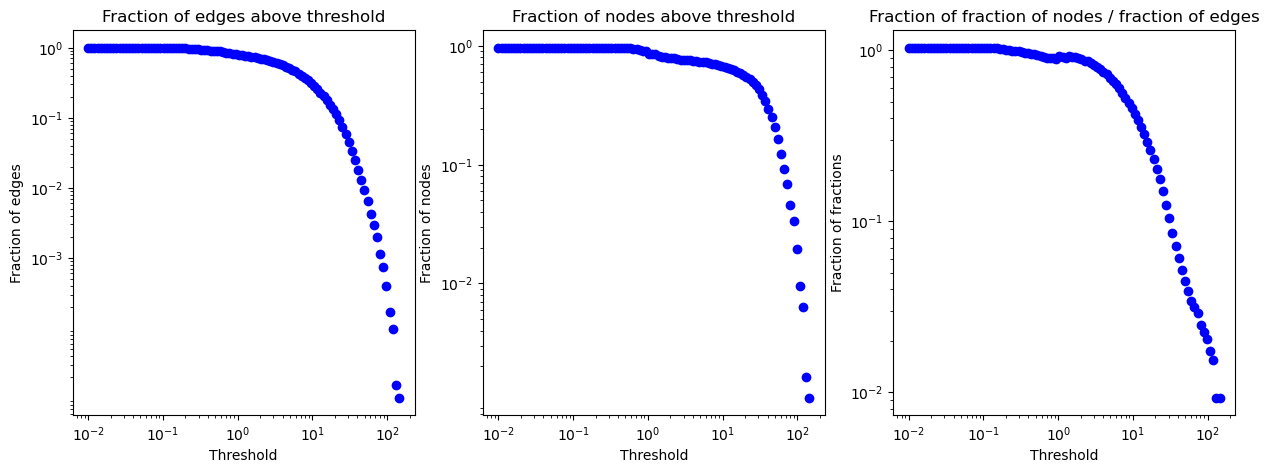

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot.plot_fraction(
    thresholds, threshold_edges_fractions, 'Fraction of edges above threshold', 'Threshold', 'Fraction of edges',
    vspan_intervals=None,
    yticks=np.array([0.001, 0.01, 0.1, 1])
)

plt.subplot(1, 3, 2)
plot.plot_fraction(
    thresholds, threshold_nodes_fractions, 'Fraction of nodes above threshold', 'Threshold', 'Fraction of nodes',
    yticks=np.array([0.01, 0.1, 1]),
)

plt.subplot(1, 3, 3)
plot.plot_fraction(
    thresholds, threshold_fraction_of_fractions, 'Fraction of fraction of nodes / fraction of edges', 'Threshold', 'Fraction of fractions',
    yticks=np.array([0.01, 0.1, 1])
)

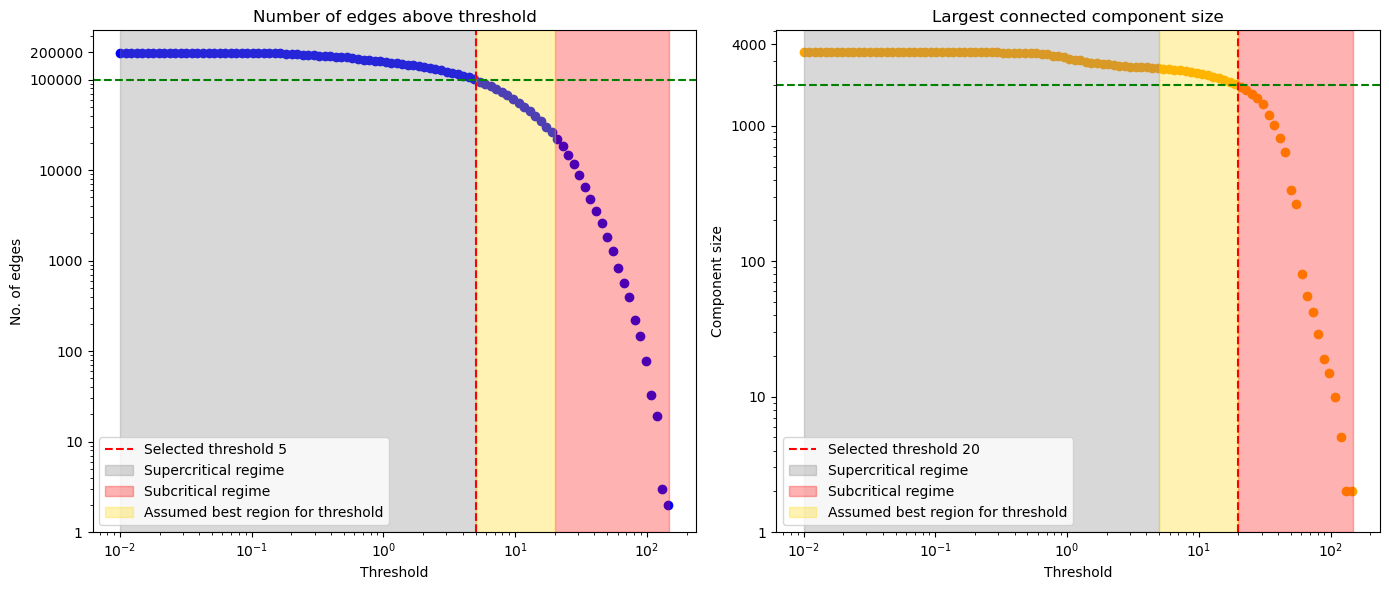

In [16]:
plot.plot_threshold_sizes_regions(
    thresholds,
    more_than_threshold,
    largest_component_sizes,)

From the plots, especially from the two plots on the second figure, what we can see is thresholding below 5 keeps too many low-impact edges (i.e. edges that probably would not exist in the graph), but thresholding above 20 results in the network falling apart. The threshold should be somewhere in the critical region, so we still have the major component not falling apart, but fairly many edges cleared out. I choose both ends: 5 to still contain most of the connections, and 20 to have a sparser, but well-connected network.

In [17]:
edges_to_remove_5 = []
edges_to_remove_20 = []
G_thresholded_5 = G.copy()
G_thresholded_20 = G.copy()
for u, v, data in G.edges(data=True):
    if data['weight'] < 20:
        edges_to_remove_20.append((u, v))
        if data['weight'] < 5:
            edges_to_remove_5.append((u, v))
G_thresholded_5.remove_edges_from(edges_to_remove_5)
G_thresholded_20.remove_edges_from(edges_to_remove_20)

nodes_to_remove = []
for node in G_thresholded_5.nodes():
    if G_thresholded_5.degree(node) == 0:
        nodes_to_remove.append(node)
G_thresholded_5.remove_nodes_from(nodes_to_remove)
nodes_to_remove
for node in G_thresholded_20.nodes():
    if G_thresholded_20.degree(node) == 0:
        nodes_to_remove.append(node)
G_thresholded_20.remove_nodes_from(nodes_to_remove)

I still had somehow 0 degree nodes (which will cause issues later), so here I decided to just select the biggest component for analysis:

In [18]:
lcc = max(nx.connected_components(G_thresholded_5), key=len)
G_thresholded_5_lcc = G_thresholded_5.subgraph(lcc).copy()

print("Number of nodes in the graph: ", G_thresholded_5.number_of_nodes(), "\nNumber of edges in the graph: ", G_thresholded_5.number_of_edges())
print("Number of nodes in the largest connected component: ", len(G_thresholded_5_lcc), "\nNumber of edges in the largest connected component: ", G_thresholded_5.subgraph(G_thresholded_5_lcc).number_of_edges())

lcc = max(nx.connected_components(G_thresholded_20), key=len)
G_thresholded_20_lcc = G_thresholded_20.subgraph(lcc).copy()

print("Number of nodes in the graph: ", G_thresholded_20.number_of_nodes(), "\nNumber of edges in the graph: ", G_thresholded_20.number_of_edges())
print("Number of nodes in the largest connected component: ", len(G_thresholded_20_lcc), "\nNumber of edges in the largest connected component: ", G_thresholded_20.subgraph(G_thresholded_20_lcc).number_of_edges())

Number of nodes in the graph:  2695 
Number of edges in the graph:  99507
Number of nodes in the largest connected component:  2664 
Number of edges in the largest connected component:  99468
Number of nodes in the graph:  2065 
Number of edges in the graph:  23954
Number of nodes in the largest connected component:  1993 
Number of edges in the largest connected component:  23896


From 3662 artists with ~200000 connections, we still kept around 100000 connections between the remaining 2664 artists & with a threshold of 20 we have a largest connected component with almost 2000 nodes, and only ~24k edges. Average degrees are around 75 and 24 respectively - the first value seems to be unrealisticly high (in this case, these artists have on average 75 connections just among themselves, and many of an artist's connections are not in the dataset).

There is also a rough interpretation of this filtering: only those artists are kept, who on average have spent at least 5 years at places where both of them lived/worked, roughly (this is not the complete picture, citizenship/nationality is considered, see the similarity measure's method).

Calculating best minimal value for power law fit
c:\Users\hanic\miniforge3\envs\netsci-course\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


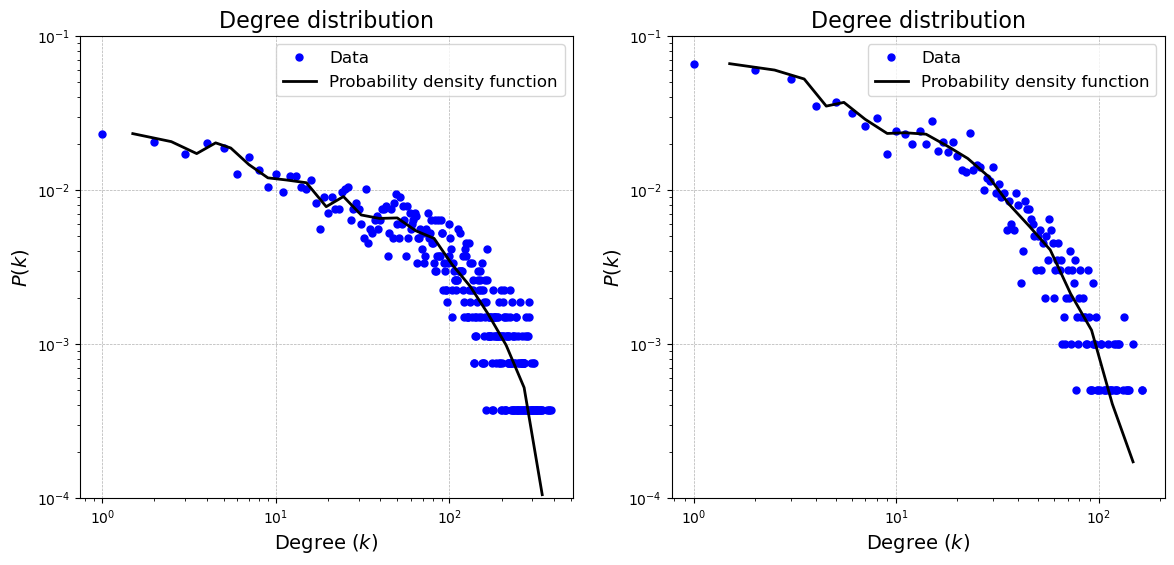

In [19]:
degrees_5 = [degree for _, degree in G_thresholded_5_lcc.degree()]
degrees_20 = [degree for _, degree in G_thresholded_20_lcc.degree()]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fit_5 = plot.plot_deg_dist_fit_log_single_pdf(degrees_5, ax[0], return_fit=True)
fit_20 = plot.plot_deg_dist_fit_log_single_pdf(degrees_20, ax[1], return_fit=True)

In [20]:
print(f'Power-law fits: networks as a result of filtering with thresholds 5 and 20 \n')
print(f'Alpha at threshold=5: {fit_5.power_law.alpha}')
print(f'KS-distance at threshold=5: {fit_5.power_law.D}')
print(f'\nAlpha at threshold=20: {fit_20.power_law.alpha}')
print(f'KS-distance at threshold=20: {fit_20.power_law.D}')

Power-law fits: networks as a result of filtering with thresholds 5 and 20 

Alpha at threshold=5: 12.288014104111404
KS-distance at threshold=5: 0.05955182148641813

Alpha at threshold=20: 5.072765245611935
KS-distance at threshold=20: 0.06658175729103336


Kolmogorov-Smirnov distance seems low in both cases, which indicates a not bad fit - however the $\alpha$ value is surprisingly high in both cases. This is an interesting observation, the ratio of nodes with small degree is much higher than in a typical social network (with $2<\alpha<3$).

It could make sense, that the bigger the network, the faster the decay, at least the mathematical parameter will be higher. As suggested by Dunbar's number, artists also must have a limited amount of connections, and in a large enough network this is exploited, because the end of the tail will not grow past a certain point (reaches 0 at the limit everytime), whereas the number of small number connections will grow. If we were to increase the threshold, the $\alpha$ value would likely decrease, as the network would be smaller and the tail would not shrink as fast as the set of small degree nodes.

Another explanation is the "historical" nature of the network - a temporal snapshot of the network (including only artists living at that moment in time) might represent a typical social network that we'd observe, however the network is more like a conglomerate of these networks - it's like a long trail of snapshots of networks. This suggests, that 

We can calculate and plot the clustering coefficient distribution of the network:

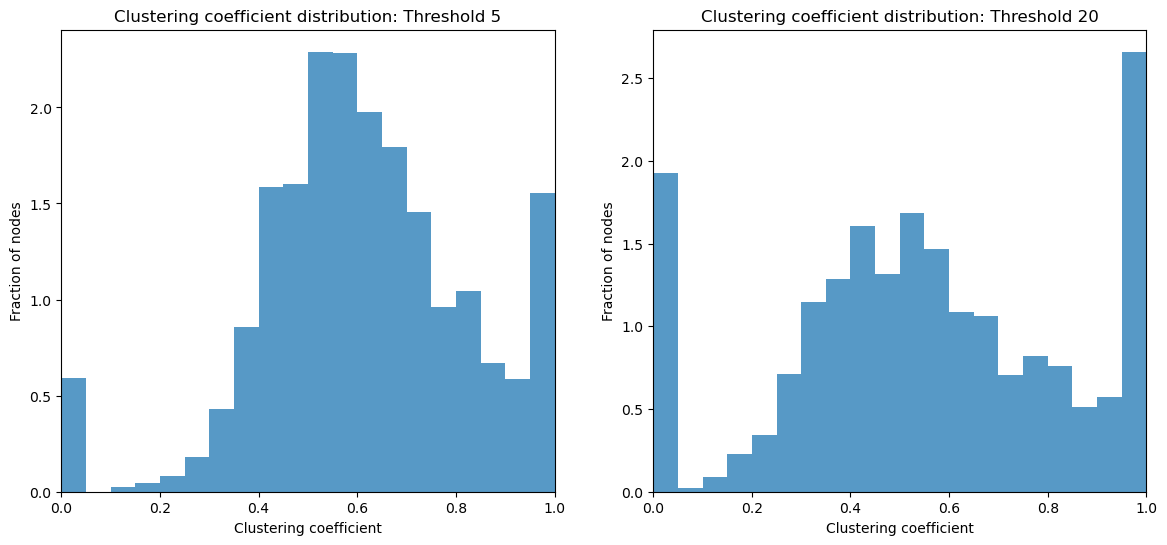

Average clustering coefficient at threshold 5: 0.6123466617754699 
Average clustering coefficient at threshold 20: 0.5505269959308988


In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
clustering_coefficients_5 = measures.clustering_coefficient(G_thresholded_5_lcc)
clustering_coefficients_20 = measures.clustering_coefficient(G_thresholded_20_lcc)
plot.plot_CC_distribution_hist(clustering_coefficients_5, ax[0])
ax[0].set_title("Clustering coefficient distribution: Threshold 5")
plot.plot_CC_distribution_hist(clustering_coefficients_20, ax[1])
ax[1].set_title("Clustering coefficient distribution: Threshold 20")
plt.show()

print(f'Average clustering coefficient at threshold 5: {np.mean(clustering_coefficients_5)}',
      f'\nAverage clustering coefficient at threshold 20: {np.mean(clustering_coefficients_20)}')

We see a high number of nodes with maximal value. With threshold 5, nodes have more weak ties, therefore the clustering coefficient is more normally distributed, most nodes have a coefficient around 0.5-0.6. With threshold 20, the network contains less inter-connections, and thus on the distribution we can see that there are many nodes with either 1 or 0 clustering coefficient.

### Method 2: Filter by disparity

Every node has a local measure for the weights of its edges (local in the sense that the values represent local importance, not for the full network). This helps to keep more edges with low weight, but with higher local importance - the expected range of weights could differ greatly throughout the network, e.g. artists living in Paris will always have many and strong connections, but other artists may not have so many high weight connections.

I use the following measure, composed of the node's strength (sum of weights) and degree, and the weight of the edge. For each edge, we define two disparity values - one for each start node i.e. direction (we have an undirected network, however this measure still can be asymmetric). The edge probability is calculated as:

$$ p_{ij} = (1 - \frac{w_{ij}}{s_{i}})^{k_i-1} $$

where $w_{ij}$ is the weight of the edge between $i$ and $j$, $s_{i}$ is the total strength of node $i$, and $k_i$ is the degree of node $i$.


(An explanation on using out-degree and out-strength for the general formula e.g. could be that hubs typically have many incoming edges but few outgoing edges, and the impact of the incoming edges can be unimportant - such as with the hyperlinks and the WWW.)

In [22]:
edge_probas = measures.compute_disparity_filter_probas(G_lcc)
alphas = np.logspace(-4.7, 0, 50) #10^-25 instead of 0

disparity_edges_fractions = []
disparity_nodes_fractions = []
for alpha in alphas:
    G_filtered = G_lcc.copy()
    for e in G_lcc.edges():
        if edge_probas[e] >= alpha:
            G_filtered.remove_edge(*e)
    G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))
    disparity_edges_fractions.append(G_filtered.number_of_edges() / G_lcc.number_of_edges())
    disparity_nodes_fractions.append(G_filtered.number_of_nodes() / G_lcc.number_of_nodes())
disparity_normalized_fractions = [e/n for e,n in zip(disparity_edges_fractions, disparity_nodes_fractions)]

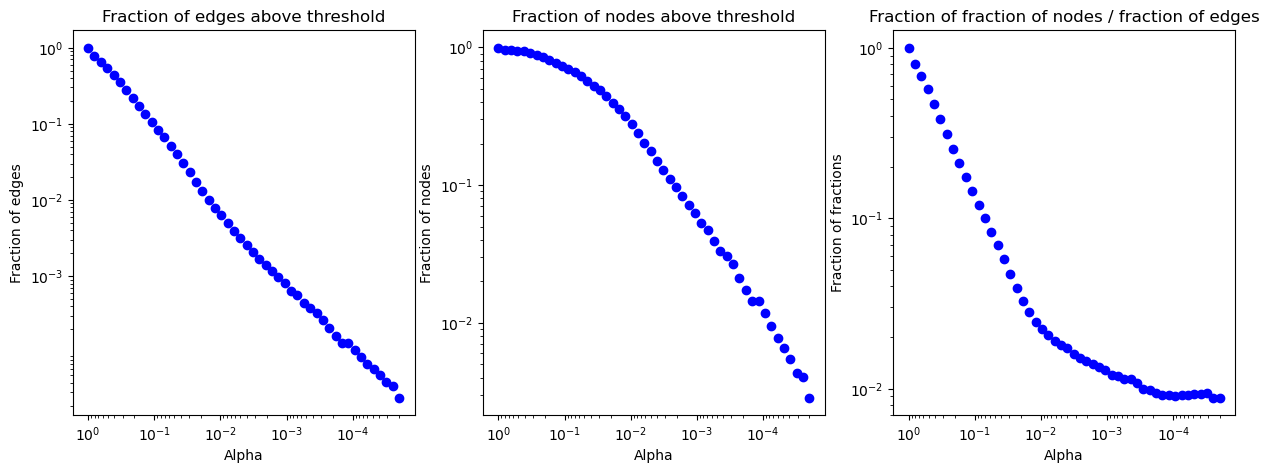

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot.plot_fraction(
    alphas, disparity_edges_fractions, 'Fraction of edges above threshold', 'Alpha', 'Fraction of edges',
    vspan_intervals=None,
    yticks=np.array([0.001, 0.01, 0.1, 1])
)
plt.gca().invert_xaxis()

plt.subplot(1, 3, 2)
plot.plot_fraction(
    alphas, disparity_nodes_fractions, 'Fraction of nodes above threshold', 'Alpha', 'Fraction of nodes',
    yticks=np.array([0.01, 0.1, 1]),
)
plt.gca().invert_xaxis()

plt.subplot(1, 3, 3)
plot.plot_fraction(
    alphas, disparity_normalized_fractions, 'Fraction of fraction of nodes / fraction of edges', 'Alpha', 'Fraction of fractions',
    yticks=np.array([0.01, 0.1, 1])
)
plt.gca().invert_xaxis()

We see a much more straighter decrease in both the fraction of edges and nodes kept. Let's filter at $\alpha = 0.7$ and $\alpha = 0.1$: these correspond in the number of edges to the threshold values 5 and 20, approximately.

In [24]:
#Two graphs: one with alpha 0.7 and one with alpha 0.1
G_filtered_07 = G_lcc.copy()
G_filtered_01 = G_lcc.copy()
edges_to_remove_01 = []
edges_to_remove_07 = []
for e in G_lcc.edges():
    if edge_probas[e] >= 0.1:
        edges_to_remove_01.append(e)
        if edge_probas[e] >= 0.7:
            edges_to_remove_07.append(e)

G_filtered_01.remove_edges_from(edges_to_remove_01)
G_filtered_07.remove_edges_from(edges_to_remove_07)

G_filtered_01.remove_nodes_from(list(nx.isolates(G_filtered_01)))
G_filtered_07.remove_nodes_from(list(nx.isolates(G_filtered_07)))

Average clustering coefficient at alpha 0.7: 0.6024707943537841 
Average clustering coefficient at alpha 0.1: 0.40486820998397305


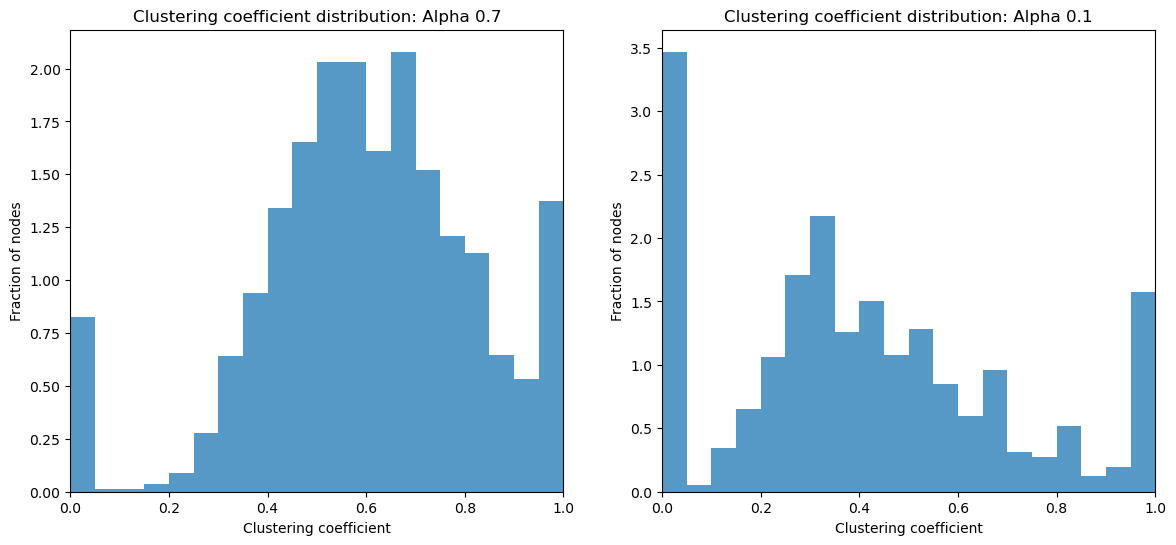

In [25]:
#Plot the histogram of clustering coefficients
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
clustering_coefficients_07 = measures.clustering_coefficient(G_filtered_07)
clustering_coefficients_01 = measures.clustering_coefficient(G_filtered_01)
plot.plot_CC_distribution_hist(clustering_coefficients_07, ax[0])
ax[0].set_title("Clustering coefficient distribution: Alpha 0.7")
plot.plot_CC_distribution_hist(clustering_coefficients_01, ax[1])
ax[1].set_title("Clustering coefficient distribution: Alpha 0.1");
print(f'Average clustering coefficient at alpha 0.7: {np.mean(clustering_coefficients_07)}',
        f'\nAverage clustering coefficient at alpha 0.1: {np.mean(clustering_coefficients_01)}')

Whilst there is still the phenomenon that many nodes have either 0 or 1 as clustering coefficient, there is a higher concentration of nodes with clustering coefficient 0, especially with $\alpha = 0.1$. This makes sense, as due to local importance more "globally weak" ties are kept, which likely means the neighbors of neighbors have lower chance of being connected - causing an increase in cases of 0 clustering coefficients.

The decrease in number of nodes with clustering coefficient 1 is much more significant - this might be due to groups of artists that are only connected to each other due to having lived at only one place; some of these artists are connected by the one and only location and hence have a clustering coefficient of 1 - the thresholding method keeps these connections as these are strong connections, but the disparity method has less of a tendency to do so, as connections are locally evaluated.


The development of the network's clustering coefficient (CC) distribution via filtering is interesting. The first method with threshold 5 gives a similar CC distribution as the disparity method with $\alpha = 0.7$, the mean is also similar - as these keep roughly the same amount of nodes and edges, we can say, that up to removing the first ~80-100k connections, neither method has a significant impact on the network's CC distribution. (It might be a bit short-sighted to believe so, but this may suggest that the first 100k connections are the redundant connections, that any "good" method would remove - everything afterwards will bring forward some sort of biases that not all good methods would also bring forward).<br>
When increasing the the threshold and decreasing the $\alpha$ value, the CC distribution changes significantly - aside from what we just mentioned, the disparity filtering method in general keeps more low weight connections, skewing the distribution towards 0, resulting in a much smaller average CC.

### Final network selection

For the remainder of the notebook, I select the network filtered by disparity with $\alpha = 0.1$ - this method seems to a more "diverse" backbone, and to save time on computation, I set the lower value of $\alpha$, keeping less edges.

In [ ]:
G = G_filtered_01.copy()
lcc = max(nx.connected_components(G), key=len)
G = G.subgraph(lcc).copy()

print("Number of nodes in the filtered graph: ", G.number_of_nodes(),
      "\nNumber of edges in the graph: ", G.number_of_edges())

with open("data/painters.graphml", "wb") as file:
    nx.write_graphml(G, file)

Number of nodes in the filtered graph:  2400 
Number of edges in the graph:  18725


## Macroscopic network analysis

### Statistics of attributes

We can analyze the distribution of various attributes of painters, such as nationality, gender, or movement they belong to. Let's see the top 10 most common values for these attributes:

(There are some mismatches in citizenship and nationality, that is due to the dataset collecting the two information from two different sources. It can also highlight historical information, such as Italy being represented by many nationalities yet, partially because it was not a unified country for a long time, has low representation in citizenship.)

We see low representation among female painters, only ~7.6% of the network are females.

In [36]:
artists_graph = list(G.nodes())
artists_graph_df = artists[artists['artist'].isin(artists_graph)]
measures.describe_measures(artists_graph_df)

Percentage of females in the graph:  7.596
Average birth year in the graph:  1779.245
Average number of pictures on WikiArt:  78.331


,Nationality,Nationality ratio,Citizenship,Citizenship ratio,Movement,Movement ratio,Styles,Styles ratio
1,American,0.168,France,0.150,Romanticism,0.107,Baroque,0.045
2,French,0.107,United States of America,0.150,Baroque,0.092,Romanticism,0.037
3,Italian,0.104,Netherlands,0.079,Realism,0.062,"Baroque, Unknown",0.026
4,British,0.098,Kingdom of the Netherlands,0.055,Expressionism,0.050,"Romanticism, Unknown",0.024
5,German,0.062,Dutch Republic,0.050,Impressionism,0.048,Realism,0.021
6,Dutch,0.056,United Kingdom,0.044,Abstract Art,0.046,Conceptual Art,0.018
7,Russian,0.037,Germany,0.043,Surrealism,0.043,Impressionism,0.016
8,Spanish,0.022,Italy,0.032,Symbolism,0.032,Surrealism,0.015
9,Flemish,0.021,Spain,0.027,Abstract Expressionism,0.031,Abstract Expressionism,0.014
10,Polish,0.016,United Kingdom of Great Britain and Ireland,0.025,Post-Impressionism,0.031,Neoclassicism,0.011


### Plots of attributes against each other

#### Percentage of females per time (centuries)

I plot the percentage of females per century, based on the birth year of the painters.

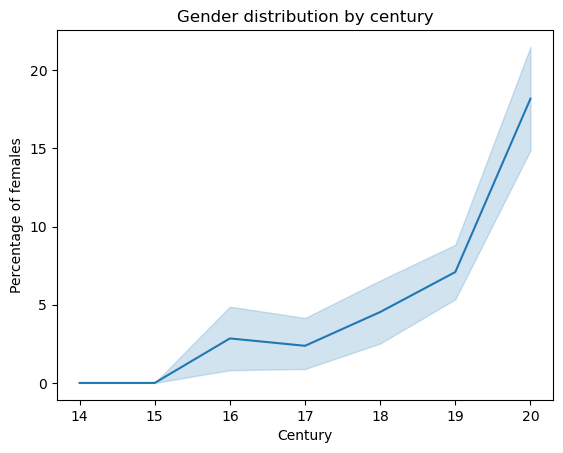

In [28]:
century_data = artists_graph_df[~np.isnan(artists_graph_df['birth_year'])]
century_data['century'] = (century_data['birth_year'] // 100 + 1).astype(int)
century_data['female'] = [100 if century_data.iloc[i]['gender'] == 'female' else 0 for i in range(len(century_data))]

sns.lineplot(x='century', y='female', data=century_data)
plt.xlabel('Century')
plt.ylabel('Percentage of females')
plt.title('Gender distribution by century')
plt.show()

We see a trend of increasing female representation over time, reaching almost 20% in the 20th century.

#### Percentage of females per nationality

I filter out any instance that has multiple nationalities (divided by comma), then groupby by country.

In [29]:
nationalities_females_df = century_data[['Nationality','female']][~century_data['Nationality'].str.contains(",", na=False)].groupby('Nationality').mean().sort_values(by='female', ascending=False)
nationalities_females_df

,female
Nationality,
South African,100.000000
Turkish,100.000000
Finnish,100.000000
Mexican,50.000000
Canadian,33.333333
Japanese,25.000000
Ukrainian,25.000000
Austrian,25.000000
Portuguese,25.000000


There are three nationalities with 100% female representation: South African, Finnish and Turkish. This of course, is because these nationalities do not represent many painters in our dataset, even less in the filtered graph, and not all collected painters have a nationality attribute - it just so happens that the 1-2 painters with these nationalities in our graph happen to be female.

Since European countries are mostly represented by artists from elder centuries, it is not surprising that they typically have below average representation in females - we have seen that it was more rare for females to be painters in the past (according to our dataset, which is not necessarily representative of the real world). The USA has ~16%, as the country is represented by many 20th century painters.

#### Average picture count on WikiArt per Nationality

WikiArt has a count of how many artworks are available for many painters - usually this is a good indicator of impact and how many artworks have survived.

In [30]:
nationalities_paintings_df = century_data[['Nationality','wikiart_pictures_count']][~century_data['Nationality'].str.contains(",", na=False)].groupby('Nationality').mean().sort_values(by='wikiart_pictures_count', ascending=False)
nationalities_paintings_df

,wikiart_pictures_count
Nationality,
Russian,198.657143
Spanish,190.476190
Italian School of Paintings,185.000000
Colombian,177.000000
French,148.517241
Austrian,130.250000
Mexican,122.500000
Norwegian,102.666667
Swedish,98.333333


Despite the high impact of Italian painters throughout history, the average picture count is not among the highest. This can be explained via thee reasons: many Italian painters are from the 15th-17th centuries, and many of their artworks are not available on WikiArt. The highest average picture count is for the USA, which is not surprising, as the USA is represented by many 20th century painters, and the USA has a high representation in the dataset.

### Centrality measures

As we try to study the nodes in the network (and not the edges), I will calculate the following centrality measures:

- Degree centrality
- Closeness centrality

These give a sense of the influence is distributed in the network (when plotted as a distribution).

In [45]:
#Degree centrality
degree_centrality = nx.degree_centrality(G)
degree_ranking = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 degree centralities: ")
for artist, degree in degree_ranking[:10]:
    print(artist, " (born in ", int(artist_data[artist]['birth_year']), ") with centrality: ", round(degree, 4))

#Closeness centrality
closeness_centrality = nx.closeness_centrality(G)
closeness_ranking = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 closeness centralities: ")
for artist, closeness in closeness_ranking[:10]:
    print(artist, " (born in ", int(artist_data[artist]['birth_year']), ") with centrality: ", round(closeness, 4))

Top 10 degree centralities: 
Paul Cadmus  (born in  1904 ) with centrality:  0.0709
Jeanne Rij-Rousseau  (born in  1870 ) with centrality:  0.0675
Richard Avedon  (born in  1923 ) with centrality:  0.0654
Louis Michel Eilshemius  (born in  1864 ) with centrality:  0.0634
Hermann-Paul  (born in  1864 ) with centrality:  0.0613
George Auriol  (born in  1863 ) with centrality:  0.06
Jean Béraud  (born in  1849 ) with centrality:  0.0579
Valentine Hugo  (born in  1887 ) with centrality:  0.055
Elliott Erwitt  (born in  1928 ) with centrality:  0.055
Henri Manuel  (born in  1874 ) with centrality:  0.0538

Top 10 closeness centralities: 
Jean Baptiste Claude Odiot  (born in  1763 ) with centrality:  0.1988
Antoine-Louis Barye  (born in  1795 ) with centrality:  0.1981
Sophie Gengembre Anderson  (born in  1823 ) with centrality:  0.1969
Charles Thévenin  (born in  1764 ) with centrality:  0.1957
Léon Cogniet  (born in  1794 ) with centrality:  0.1957
Jean Victor Bertin  (born in  1767 ) with

As we see totally different names, we realize that in this network, basic centrality measures do not really capture impact. Degree centrality is biased to artists living in the 20th century, because of data imbalance (there are more records of newer artists).<br>
Closeness centrality is biased to nodes at the "center of time". As this is a historical network, its structure is a longitudinal "chain" of networks, and the closeness centrality will be highest for nodes in the middle of the chain. We do not calculate betweenness centrality as it is for edges, however it would have the same issue.

It rather would make sense, to take a snapshot of the network at a certain time, and calculate the centrality measures and distributions for that network. That is incomplete, but give a more accurate representation of the impact of painters in their time.

### A snapshot of the network

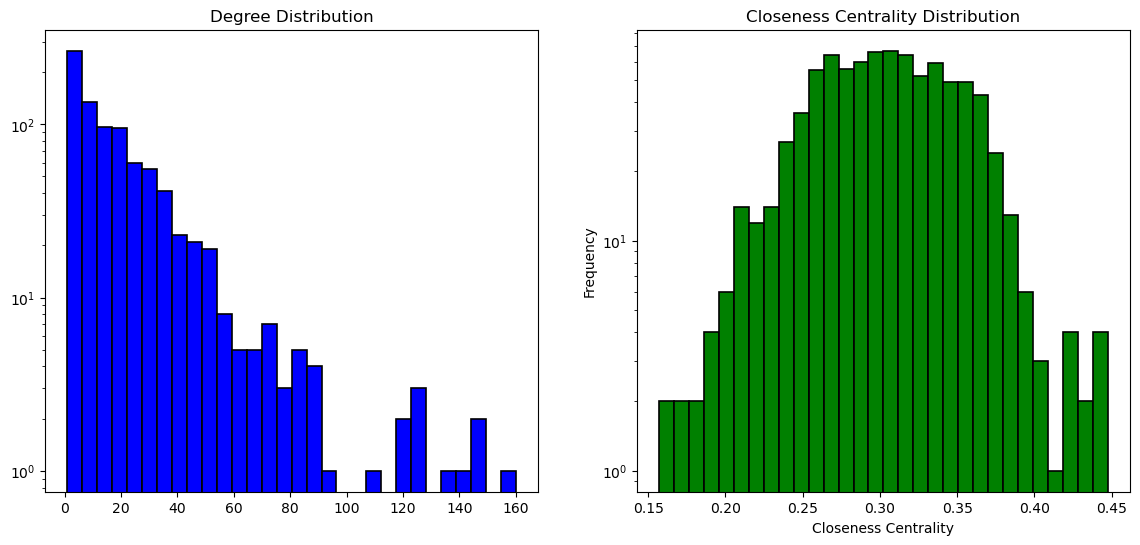

Top 10 artists by degree centrality:
Jeanne Rij-Rousseau: 160
Louis Michel Eilshemius: 149
Hermann-Paul: 147
George Auriol: 144
Jean Béraud: 137
Henri Manuel: 128
Valentine Hugo: 127
Gabriel Argy-Rousseau: 125
Constant Puyo: 122
Boleslas Biegas: 119

Top 10 artists by closeness centrality:
Jeanne Rij-Rousseau: 0.4474
Louis Michel Eilshemius: 0.4446
Hermann-Paul: 0.4403
George Auriol: 0.4392
Jean Béraud: 0.4332
Henri Manuel: 0.4310
René Lalique: 0.4223
Constant Puyo: 0.4223
Boleslas Biegas: 0.4211
Gabriel Argy-Rousseau: 0.4184


In [60]:
#Years: rougly 1850-1950 We select artists having lived their 30th birthday this period
artists_snapshot = {artist: data for artist, data in artist_data.items()
                    if (1820 <= data['birth_year'] <= 1920) and (data['death_year'] - data['birth_year'] >= 30)}
G_snapshot = G.subgraph(artists_snapshot.keys()).copy()
G_snapshot = G_snapshot.subgraph(max(nx.connected_components(G_snapshot), key=len)).copy()

degrees = [int(degree) for _, degree in G_snapshot.degree()]
#Degree centrality distribution (histogram)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(degrees, bins=30, color='blue', edgecolor='black', linewidth=1.2, log=True)
plt.xlabel('Degree')
plt.ylabel('Frequency')
ax[0].set_title('Degree Distribution')

# Closeness centrality distribution (histogram)
closeness_centrality = nx.closeness_centrality(G_snapshot)
closeness_values = list(closeness_centrality.values())
ax[1].hist(closeness_values, bins=30, color='green', edgecolor='black', linewidth=1.2, log=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
ax[1].set_title('Closeness Centrality Distribution')
plt.show()

# Print top 10 most central artists by degree
degree_ranking = sorted(G_snapshot.degree, key=lambda x: x[1], reverse=True)
print("Top 10 artists by degree centrality:")
for artist, degree in degree_ranking[:10]:
    print(f"{artist}: {degree}")

# Print top 10 most central artists by closeness centrality
closeness_ranking = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 artists by closeness centrality:")
for artist, closeness in closeness_ranking[:10]:
    print(f"{artist}: {closeness:.4f}")

In this case, we got much similar results, as most of the bias is reduced - although we got not the most notable artists, as one would expect impressionists to dominate these centrality lists.

We can also fit a power law on the snapshot:

Calculating best minimal value for power law fit


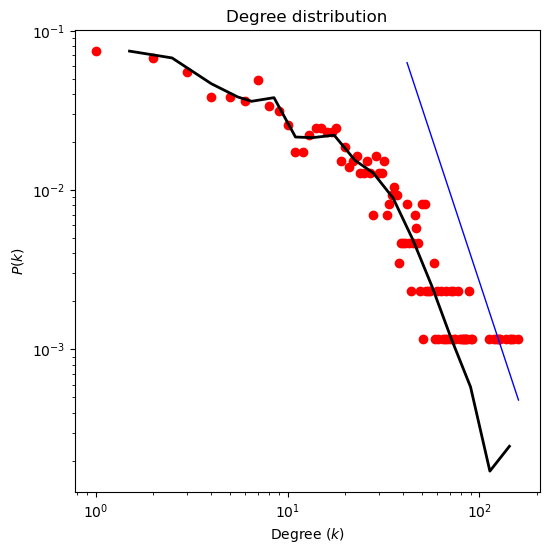

In [55]:
plot.plot_deg_dist_fit_log_single(degrees)

The slope of the fit is roughly -3.6, this alpha is more typical than the previous ones (although the number of nodes is also much smaller).

### Assortativity, rich-club behavior

Because there are "location hubs" such as Paris, that connect a lot of artists with each other, we expect a high assortativity in the network, and along with that, a rich-club behavior.

Our method to find these firstly is plot the average degree of the neighbors of a node, against the degree of the node itself. If we see an upward trend, then nodes with higher degree have neighbors with higher degree, which is a sign of assortativity, and this is what we expect. The other method is to calculate the rich-club coefficients, which is the ratio of the number of edges between nodes with degree higher than a certain value, and we compare this against a random network's rich-club coefficients. If they are higher, i.e. the plot has values above 1, then we have a rich-club behavior - we expect higher than 1 values for large enough degrees.

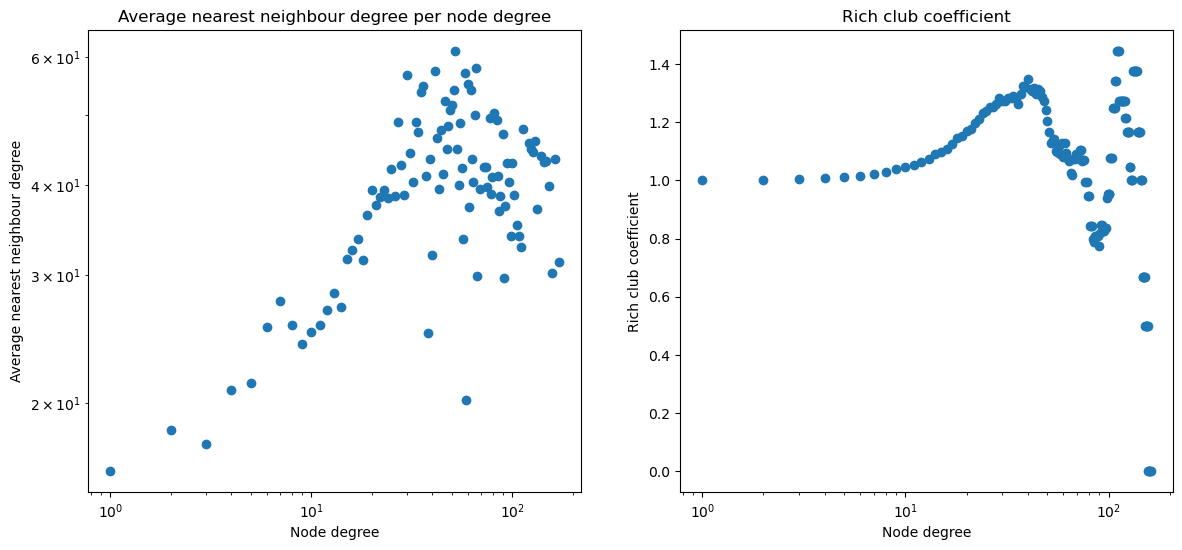

In [32]:
k_nn_dict = {node: {"degree": degree,
                    "k_nn": measures.neighbours_avg_degree(G, node)} 
                    for node, degree in G.degree()}
k_nn_values_per_k = measures.average_knn(k_nn_dict)
rich_club_coefficients = nx.rich_club_coefficient(G, normalized=True, seed=1104)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot.plot_values_per_k(k_nn_values_per_k, ax[0])
plot.plot_values_per_k(rich_club_coefficients, ax[1], yscale = "linear", title = "Rich club coefficient", ylabel = "Rich club coefficient")

From both plots, without fitting a line, we can see that there is assortativity and rich-club behavior in the network, and our hypotheses were correct. This is typical for many (offline) social networks.

## Community detection